In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FixedLocator
from matplotlib.gridspec import GridSpec

import astropy.constants as const
import tables

from scipy.signal import savgol_filter

In [2]:
%matplotlib notebook

In [3]:
# meta data
z = 0.0094
tb_max = 58863.34
t_fl = -17.4928

In [4]:
abs_mag_df = pd.read_csv('abs_mag_p48.csv')
abs_mag_df.head(5)

,t_restframe,abs_mag,mag_unc,filt
0,0.779844,-16.121753,0.015658,r
1,0.847793,-15.760670,0.014474,i
2,0.867332,-16.364536,0.010132,g
3,3.731084,-16.083966,0.017258,r
4,3.789436,-15.874392,0.015882,g


In [5]:
models_df = pd.read_csv('../data/models/polin2019/Mtot_0.96/0.92_0.04_doubledet.mag', 
                        delim_whitespace=True, comment='#',
                        names = ['time', 'Lbol', 'Mbol', 
                                    'ZTF_g', 'ZTF_r', 'ZTF_i', 
                                    'uvw2', 'uvm2', 'uvw1', 'u', 'b', 'v'])
models_df.head()

,time,Lbol,Mbol,ZTF_g,ZTF_r,ZTF_i,uvw2,uvm2,uvw1,u,b,v
0,0.05,1.000000e-10,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,0.15,1.000000e-10,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,0.25,1.553813e+40,-11.78107,-10.70353,-10.77827,-10.41040,-10.37931,-10.47036,-10.63125,-10.86153,-10.80783,-10.43487
3,0.35,1.052898e+41,-13.85854,-12.41576,-12.26163,-11.90686,-12.37787,-12.50525,-12.39935,-12.68548,-12.59342,-12.22220
4,0.45,3.627155e+41,-15.20149,-13.26546,-13.19983,-12.61924,-13.68696,-13.82780,-13.65307,-13.57273,-13.35879,-13.35785


In [6]:
# figure out time offset
t_grid = np.linspace(0,5,126)
r_early = np.where((abs_mag_df.filt == 'r') & 
                   (abs_mag_df.t_restframe <= 30))
g_early = np.where((abs_mag_df.filt == 'g') & 
                   (abs_mag_df.t_restframe <= 30))
i_early = np.where((abs_mag_df.filt == 'i') & 
                   (abs_mag_df.t_restframe <= 30))

chi2_grid = np.zeros_like(t_grid)
for tnum, toff in enumerate(t_grid):
    model = np.interp(abs_mag_df.t_restframe.iloc[r_early], models_df.time.values - toff, models_df.ZTF_r)
    chi2_grid[tnum] += np.sum((abs_mag_df.abs_mag.iloc[r_early].values - model)**2/abs_mag_df.mag_unc.iloc[r_early].values**2)

#     model = np.interp(abs_mag_df.t_restframe.iloc[g_early], models_df.time.values - toff, models_df.ZTF_g)
#     chi2_grid[tnum] += np.sum((abs_mag_df.abs_mag.iloc[g_early].values - model)**2/abs_mag_df.mag_unc.iloc[g_early].values**2)

    model = np.interp(abs_mag_df.t_restframe.iloc[i_early], models_df.time.values - toff, models_df.ZTF_i)
    chi2_grid[tnum] += np.sum((abs_mag_df.abs_mag.iloc[i_early].values - model)**2/abs_mag_df.mag_unc.iloc[i_early].values**2)
    
print(t_grid[np.argmin(chi2_grid)])

0.72


<IPython.core.display.Javascript object>


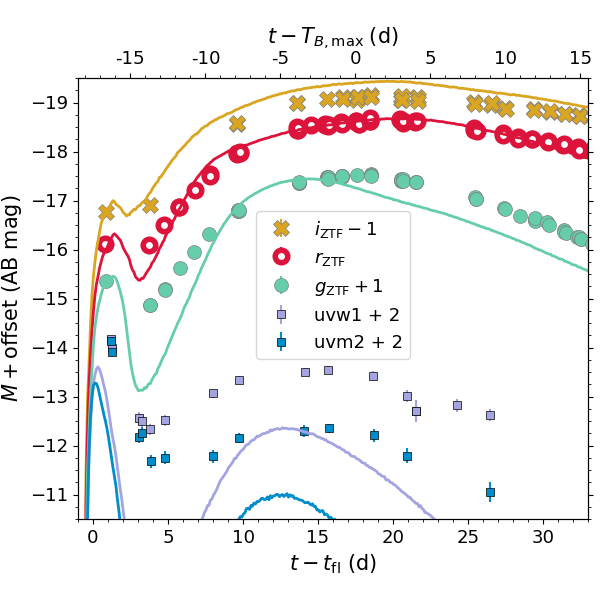

In [7]:
color_dict = {1: 'MediumAquaMarine',
              2: 'Crimson', 
              3: 'Goldenrod', 
              "uvw2": "#D71DE5",
              "uvm2": "#008DCB",
              "uvw1": "#A4A4E3"}

mark_color_dict = {2: 'white',
                   1: 'MediumAquaMarine',
                   3: 'Goldenrod'}
sym_dict = {1: 'o',
            2: 'o',
            3: 'X'}
mec_dict = {2: 'Crimson',
            1: '0.5',
            3: '0.5'}
mew_dict = {2: 4,
            1: 0.5,
            3: 0.5}
ms_dict = {2: 9,
           1: 10,
           3: 12}
filt_dict = {1:'g', 
             2:'r', 
             3:'i'}
label_dict = {1:r'$g_\mathrm{ZTF} + 1$', 
             2:r'$r_\mathrm{ZTF}$', 
             3:r'$i_\mathrm{ZTF} - 1$'}
zorder_dict = {3: 10,
               1: 5,
               2: 2}
offset_dict = {3: -1,
               1: 1,
               2: 0,
               "uvw2": 4,
               "uvm2": 2,
               "uvw1": 2}

t_offset = 0.72

fig, ax = plt.subplots(figsize=(6,6))

for filt in [3,2,1]:
    this_filt = np.where(abs_mag_df.filt == filt_dict[filt])
    
    ax.errorbar(abs_mag_df.t_restframe.values[this_filt], 
                abs_mag_df.abs_mag.values[this_filt] + offset_dict[filt], 
                abs_mag_df.mag_unc.values[this_filt], 
                fmt = sym_dict[filt], color=mark_color_dict[filt], ecolor=color_dict[filt],
                mec=mec_dict[filt], mew=mew_dict[filt],
                label = label_dict[filt], zorder = zorder_dict[filt], 
                ms=ms_dict[filt])
    
    ax.plot(models_df.time.values-t_offset, 
            models_df['ZTF_{}'.format(filt_dict[filt])].values + offset_dict[filt], 
            color=color_dict[filt], 
            lw=2, zorder=100)



uvw1_obs = np.where(abs_mag_df.filt == 'UVW1')
ax.errorbar(abs_mag_df.t_restframe.values[uvw1_obs], 
            abs_mag_df.abs_mag.values[uvw1_obs]  + offset_dict['uvw1'], 
            abs_mag_df.mag_unc.values[uvw1_obs],
            fmt = 's', color=color_dict['uvw1'], ecolor=color_dict['uvw1'],
            mec='k', mew=0.5,
            label='uvw1 + 2')
ax.plot(models_df.time.values-t_offset, 
        models_df['uvw1'].values  + offset_dict['uvw1'], 
        color=color_dict['uvw1'], 
        lw=2, zorder=100)

uvm2_obs = np.where(abs_mag_df.filt == 'UVM2')
ax.errorbar(abs_mag_df.t_restframe.values[uvm2_obs], 
            abs_mag_df.abs_mag.values[uvm2_obs]  + offset_dict['uvm2'], 
            abs_mag_df.mag_unc.values[uvm2_obs],
            fmt = 's', color=color_dict['uvm2'], ecolor=color_dict['uvm2'],
            mec='k', mew=0.5,
            label='uvm2 + 2')
ax.plot(models_df.time.values-t_offset, 
        models_df['uvm2'].values  + offset_dict['uvm2'], 
        color=color_dict['uvm2'], 
        lw=2, zorder=100)

# uvw2_obs = np.where(abs_mag_df.filt == 'UVW2')
# ax.errorbar(abs_mag_df.t_restframe.values[uvw2_obs], 
#             abs_mag_df.abs_mag.values[uvw2_obs]  + offset_dict['uvw2'], 
#             abs_mag_df.mag_unc.values[uvw2_obs],
#             fmt = 's', color=color_dict['uvw2'], ecolor=color_dict['uvw2'],
#             mec='k', mew=0.5,
#             label='uvw2 + 2')
# ax.plot(models_df.time.values-t_offset, 
#         models_df['uvw2'].values  + offset_dict['uvw2'], 
#         color=color_dict['uvw2'], 
#         lw=2, zorder=100)


ax.set_ylim(-10.5, -19.5)
ax.set_ylabel(r'$M + \mathrm{offset}$ (AB mag)', fontsize=15)
ax.yaxis.set_minor_locator(MultipleLocator(0.25))
ax.yaxis.set_major_locator(MultipleLocator(1))

ax.set_xlim(-1, 33)
ax.set_xlabel(r'$t - t_\mathrm{fl}$ (d)', fontsize=15)
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.tick_params(which='both', right=True, labelsize=13)

ax.legend(loc=10, fontsize=13,bbox_to_anchor=(0.5,0.53,0,0))

ax2 = ax.twiny()
ax2.set_xlabel(r"$t - T_{B,\mathrm{max}} \; (\mathrm{d})$", fontsize = 15)
ax2.set_xlim(ax.get_xlim())

bmax_ticks = np.arange(-15,20,5)
ax2.set_xticks(np.array(bmax_ticks) - t_fl)
ax2.set_xticklabels(bmax_ticks, fontsize = 12)
ax2.xaxis.set_minor_locator(FixedLocator(np.linspace(-20, 20, 41) - t_fl))
ax2.tick_params(labelsize=13)


fig.subplots_adjust(top=0.87,right=0.98,bottom=0.135, left=0.13)
# fig.savefig('../paper/figures/double_det.pdf')

## Plot spectra and light curve

In [8]:
h5file = tables.open_file('../data/models/polin2019/forAdam/0.94_0.02_doubledet.h5', mode="r")
Lnu = np.zeros((500, 5206))
for r_num, r in enumerate(h5file.root.Lnu):
    Lnu[r_num] = r

nu = np.zeros(5206)
for r_num, r in enumerate(h5file.root.nu):
    nu[r_num] = r
wave = const.c.to('Angstrom/s').value/nu
Llambda = nu**2/const.c.to('Angstrom/s').value*Lnu

In [9]:
np.max(Llambda[180].T)

2.5243476897716225e+39

In [10]:
def plot_box_spec(wave, flux): 
    flux_plot = np.repeat(flux, 2)
    wv_plot = wave.copy()
    wv_plot[:-1] += np.diff(wave)/2
    wv_plot = np.append(wave[0]-(wave[1]-wave[0])/2, 
                        np.append(np.repeat(wv_plot[0:-1], 2), 
                                  wave[-1]+(wave[-1]-wave[-2])/2))
    
    return wv_plot, flux_plot

<IPython.core.display.Javascript object>


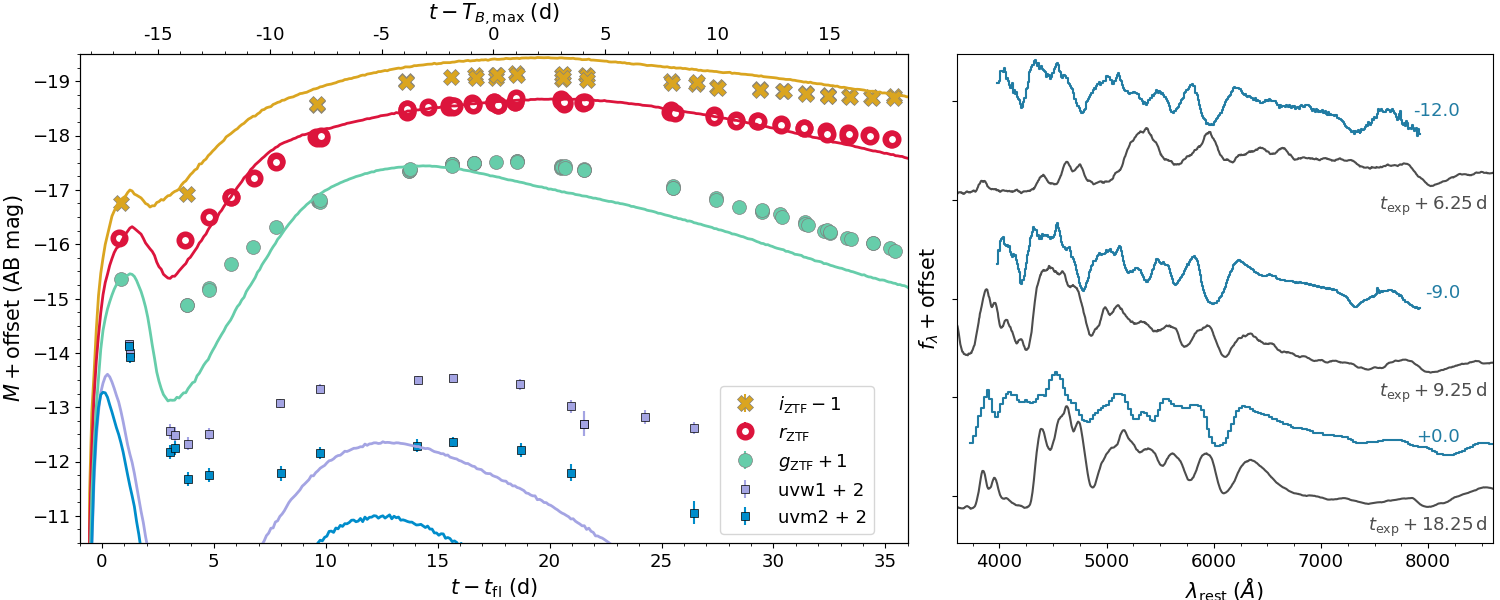

/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/matplotlib/figure.py:2144: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  warnings.warn("This figure was using constrained_layout==True, "


In [11]:
aam_colors = {'mustard': "#E29930",
             'blue': "#217CA3",
             'asphalt': "#32384D",
             'navy': "#444C5C",
             'punch': "#CE5A57",
             'ocean': "#78A5A3",
             'warm': "#E1B16A",}

fig = plt.figure(figsize=(15,6), constrained_layout=True)

gs = GridSpec(1, 5, figure=fig)
ax = fig.add_subplot(gs[:, 0:3])
# identical to ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=3))
ax_spec = fig.add_subplot(gs[:, 3:])

for filt in [3,2,1]:
    this_filt = np.where(abs_mag_df.filt == filt_dict[filt])
    
    ax.errorbar(abs_mag_df.t_restframe.values[this_filt], 
                abs_mag_df.abs_mag.values[this_filt] + offset_dict[filt], 
                abs_mag_df.mag_unc.values[this_filt], 
                fmt = sym_dict[filt], color=mark_color_dict[filt], ecolor=color_dict[filt],
                mec=mec_dict[filt], mew=mew_dict[filt],
                label = label_dict[filt], zorder = zorder_dict[filt], 
                ms=ms_dict[filt])
    
    ax.plot(models_df.time.values-0.8, 
            models_df['ZTF_{}'.format(filt_dict[filt])].values + offset_dict[filt], 
            color=color_dict[filt], 
            lw=2, zorder=100)



uvw1_obs = np.where(abs_mag_df.filt == 'UVW1')
ax.errorbar(abs_mag_df.t_restframe.values[uvw1_obs], 
            abs_mag_df.abs_mag.values[uvw1_obs]  + offset_dict['uvw1'], 
            abs_mag_df.mag_unc.values[uvw1_obs],
            fmt = 's', color=color_dict['uvw1'], ecolor=color_dict['uvw1'],
            mec='k', mew=0.5,
            label='uvw1 + 2')
ax.plot(models_df.time.values-0.8, 
        models_df['uvw1'].values  + offset_dict['uvw1'], 
        color=color_dict['uvw1'], 
        lw=2, zorder=100)

uvm2_obs = np.where(abs_mag_df.filt == 'UVM2')
ax.errorbar(abs_mag_df.t_restframe.values[uvm2_obs], 
            abs_mag_df.abs_mag.values[uvm2_obs]  + offset_dict['uvm2'], 
            abs_mag_df.mag_unc.values[uvm2_obs],
            fmt = 's', color=color_dict['uvm2'], ecolor=color_dict['uvm2'],
            mec='k', mew=0.5,
            label='uvm2 + 2')
ax.plot(models_df.time.values-0.8, 
        models_df['uvm2'].values  + offset_dict['uvm2'], 
        color=color_dict['uvm2'], 
        lw=2, zorder=100)

# uvw2_obs = np.where(abs_mag_df.filt == 'UVW2')
# ax.errorbar(abs_mag_df.t_restframe.values[uvw2_obs], 
#             abs_mag_df.abs_mag.values[uvw2_obs]  + offset_dict['uvw2'], 
#             abs_mag_df.mag_unc.values[uvw2_obs],
#             fmt = 's', color=color_dict['uvw2'], ecolor=color_dict['uvw2'],
#             mec='k', mew=0.5,
#             label='uvw2 + 2')
# ax.plot(models_df.time.values-0.8, 
#         models_df['uvw2'].values  + offset_dict['uvw2'], 
#         color=color_dict['uvw2'], 
#         lw=2, zorder=100)


ax.set_ylim(-10.5, -19.5)
ax.set_ylabel(r'$M + \mathrm{offset}$ (AB mag)', fontsize=15)
ax.yaxis.set_minor_locator(MultipleLocator(0.25))
ax.yaxis.set_major_locator(MultipleLocator(1))

ax.set_xlim(-1, 36)
ax.set_xlabel(r'$t - t_\mathrm{fl}$ (d)', fontsize=15)
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.tick_params(which='both', labelsize=13)

ax.legend(loc=4, fontsize=13,bbox_to_anchor=(0.97,0.0,0,0))

ax2 = ax.twiny()
ax2.set_xlabel(r"$t - T_{B,\mathrm{max}} \; (\mathrm{d})$", fontsize = 15)
ax2.set_xlim(ax.get_xlim())

bmax_ticks = np.arange(-15,20,5)
ax2.set_xticks(np.array(bmax_ticks) - t_fl)
ax2.set_xticklabels(bmax_ticks, fontsize = 12)
ax2.xaxis.set_minor_locator(FixedLocator(np.linspace(-20, 20, 41) - t_fl))
ax2.tick_params(labelsize=13)


# plot the spectra

# 6.25 d after explosion = -12 phase spectrum
norm_flux = np.median(Llambda[62].T[np.where((wave > 6400) & (wave < 6600))])
ax_spec.plot(wave, savgol_filter(Llambda[62].T, 21, 2)/norm_flux,
             '0.3')

spec_file = '../data/spectra/ZTF19adcecwu_20200103_LT_v1.ascii'
spec_df = pd.read_csv(spec_file, comment='#', delim_whitespace=True, header=None)
wv, fl = plot_box_spec(spec_df[0].values, spec_df[1].values)
norm_flux = np.median(fl[np.where((wv > 6400) & (wv < 6550))])
ax_spec.plot(wv/(1+z), fl/norm_flux + 1, color=aam_colors['blue'])

ax_spec.text(8300, 1.7, '-12.0', 
             color=aam_colors['blue'], fontsize=13, ha='right')
ax_spec.text(8550, -0.2, r'$t_\mathrm{exp} + 6.25\,\mathrm{d}$', 
             color='0.3', fontsize=13, ha='right')

# 9.25 d after explosion = -9 phase spectrum
norm_flux = np.median(Llambda[92].T[np.where((wave > 6400) & (wave < 6600))])
ax_spec.plot(wave, savgol_filter(Llambda[92].T, 21, 2)/norm_flux - 3.9,
             '0.3')

spec_file = '../data/spectra/ZTF19adcecwu_20200106_LT_v1.ascii'
spec_df = pd.read_csv(spec_file, comment='#', delim_whitespace=True, header=None)
wv, fl = plot_box_spec(spec_df[0].values, spec_df[1].values)
norm_flux = np.median(fl[np.where((wv > 6400) & (wv < 6550))])
ax_spec.plot(wv/(1+z), fl/norm_flux -2.5, color=aam_colors['blue'])

ax_spec.text(8300, -2., '-9.0', 
             color=aam_colors['blue'], fontsize=13, ha='right')
ax_spec.text(8550, -4., r'$t_\mathrm{exp} + 9.25\,\mathrm{d}$', 
             color='0.3', fontsize=13, ha='right')

# 18.25 d after explosion = +0 phase spectrum
norm_flux = np.median(Llambda[182].T[np.where((wave > 6400) & (wave < 6600))])
ax_spec.plot(wave, savgol_filter(Llambda[182].T, 21, 2)/norm_flux -6.5,
             '0.3')

spec_file = '../data/spectra/ZTF19adcecwu_20200115_P60_v1.ascii'
spec_df = pd.read_csv(spec_file, comment='#', delim_whitespace=True, header=None)
wv, fl = plot_box_spec(spec_df[0].values, spec_df[1].values)
norm_flux = np.median(fl[np.where((wv > 6400) & (wv < 6550))])
ax_spec.plot(wv/(1+z), fl/norm_flux - 5.3, color=aam_colors['blue'])

ax_spec.text(8300, -4.9, '+0.0', 
             color=aam_colors['blue'], fontsize=13, ha='right')
ax_spec.text(8550, -6.7, r'$t_\mathrm{exp} + 18.25\,\mathrm{d}$', 
             color='0.3', fontsize=13, ha='right')


ax_spec.set_xlim(3600,8600)
ax_spec.set_yticklabels([])
ax_spec.set_ylabel(r'$f_\lambda + \mathrm{offset}$', fontsize=15)
ax_spec.set_xlabel(r'$\lambda_\mathrm{rest} \;  (\AA)$', fontsize=15)
ax_spec.set_ylim(-6.95,2.95)
ax_spec.tick_params(labelsize=13)
ax_spec.xaxis.set_minor_locator(MultipleLocator(250))

fig.subplots_adjust(top=0.91,bottom=0.095,right=0.995,left=0.053)
fig.savefig('../paper/figures/double_det.pdf')